In [1]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('K_means').getOrCreate()

In [2]:
df=spark.read.csv('iris_dataset.csv',inferSchema=True,header=True)


In [3]:
print((df.count(), len(df.columns)))


(150, 5)


In [4]:
df.printSchema()


root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [5]:
from pyspark.sql.functions import rand
df.orderBy(rand()).show(10,False)
df.groupBy('species').count().orderBy('count').show(10,False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|6.0         |2.7        |5.1         |1.6        |versicolor|
|6.3         |3.3        |4.7         |1.6        |versicolor|
|5.1         |3.5        |1.4         |0.3        |setosa    |
|5.2         |4.1        |1.5         |0.1        |setosa    |
|6.7         |3.3        |5.7         |2.5        |virginica |
|7.7         |3.8        |6.7         |2.2        |virginica |
|7.7         |3.0        |6.1         |2.3        |virginica |
|7.2         |3.6        |6.1         |2.5        |virginica |
|5.4         |3.9        |1.3         |0.4        |setosa    |
|4.9         |2.4        |3.3         |1.0        |versicolor|
+------------+-----------+------------+-----------+----------+
only showing top 10 rows

+----------+-----+
|species   |count|
+----------+-----+
|virginica |50   |
|versicolor|50  

In [6]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
vec_assembler = VectorAssembler(inputCols = input_cols,outputCol='features')
final_data = vec_assembler.transform(df)

In [16]:
from pyspark.ml.clustering import KMeans
errors=[]
for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(final_data)

In [17]:
kmeans = KMeans(featuresCol='features',k=3)
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('prediction').count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|   38|
|         2|   62|
|         0|   50|
+----------+-----+



In [18]:
predictions=model.transform(final_data)
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   14|
|    setosa|         0|   50|
| virginica|         1|   36|
|versicolor|         1|    2|
|versicolor|         2|   48|
+----------+----------+-----+



In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
pandas_df = predictions.toPandas()
pandas_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
0,5.1,3.5,1.4,0.2,setosa,"[5.1, 3.5, 1.4, 0.2]",0
1,4.9,3.0,1.4,0.2,setosa,"[4.9, 3.0, 1.4, 0.2]",0
2,4.7,3.2,1.3,0.2,setosa,"[4.7, 3.2, 1.3, 0.2]",0
3,4.6,3.1,1.5,0.2,setosa,"[4.6, 3.1, 1.5, 0.2]",0
4,5.0,3.6,1.4,0.2,setosa,"[5.0, 3.6, 1.4, 0.2]",0


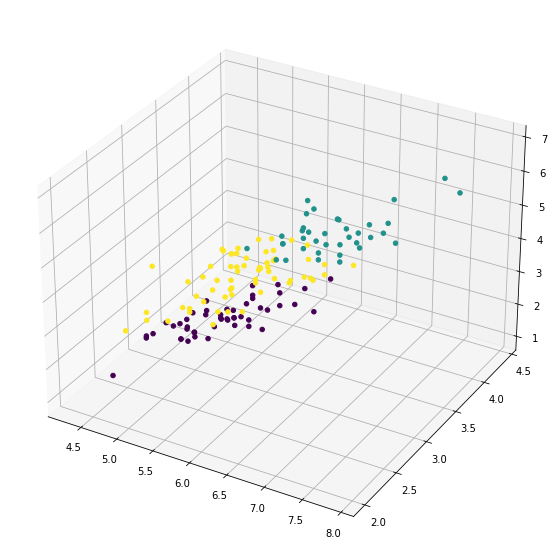

In [21]:
from mpl_toolkits.mplot3d import Axes3D
cluster_vis = plt.figure(figsize=(12,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()